In [1]:
import tensorflow as tf
import keras
from keras_facenet import FaceNet
from keras.models import load_model
from scipy import misc

Using TensorFlow backend.


In [2]:
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import pandas as pd
import sklearn
import os

In [3]:
from AIengine import *
ai_engine = AIengine('./models')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:820: UserWarning: inception_resnet_v1 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
W0524 12:17:15.866050 140262257911616 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


./models/model.pkl
Loading AI Engine


In [4]:
net = cv2.dnn.readNetFromCaffe('./cv2/deploy.prototxt.txt', './cv2/res10_300x300_ssd_iter_140000.caffemodel')

In [68]:
def random_rotate_image(image):
    angle = np.random.uniform(low=-10.0, high=10.0)
    return misc.imrotate(image, angle, 'bicubic')
  
def face_extract_dnn(img, margin=0, image_size=160, model=cv2_face_detector):
    try:
        (h, w) = img.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (image_size, image_size)), 1.0, (image_size, image_size), (103.93, 116.77, 123.68))
        model.setInput(blob)
        detections = model.forward()
        confidence = detections[0, 0, 0, 2]
        if confidence >= 0.55:
            box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            (x, y, p, q) = box.astype('int')
            (y1, y2, x1, x2) = (y-margin//2,q+margin//2, x-margin//2,p+margin//2)
            (x1, y1) = [0 if i<0 else i for i in (x1, y1)]
            faceDetected = (x1, y1, x2, y2) 
            cropped = img[y1:y2, x1:x2, :]
            _img = resize(cropped, (image_size, image_size),
                          mode='reflect')
            return _img, faceDetected
        else:
            return img, False
    except Exception as e:
        print("Error in face_extract_dnn")
        print(e)
        print("\t\t" + str(confidence) + " " + str(faceDetected))
        return img, False
    return None

def prewhiten(x):
        if x.ndim == 4:
            axis = (1, 2, 3)
            size = x[0].size
        elif x.ndim == 3:
            axis = (0, 1, 2)
            size = x.size
        else:
            raise ValueError('Dimension should be 3 or 4')

        mean = np.mean(x, axis=axis, keepdims=True)
        std = np.std(x, axis=axis, keepdims=True)
        std_adj = np.maximum(std, 1.0/np.sqrt(size))
        y = (x - mean) / std_adj
        return y

def preprocess(images, margin=0, image_size=160, model_path='./cv2/haarcascade_frontalface_alt2.xml', face_extract_algo=face_extract_dnn):
        try:
            faceDetected = True
            aligned_images = []
            for img in images:
                # print(filepath)
                if type(img) is list:
                    img = np.array(img)
                img = to_rgb(img)
                img, faceDetected = face_extract_dnn(img, margin)
                if faceDetected is False:
                    #cv2.imshow('frame', img)
                    # img, faceDetected = AIengine.face_extract_haar(img)
                    # if faceDetected is False:
                    #    continue
                    continue
                aligned_images.append(img)
            if len(aligned_images) == 0:
                return images, False
            return np.array(aligned_images), faceDetected
        except Exception as e:
            print("Error in Preprocess ")
            print(e)
            return images, False

(20, 15, 124, 146)


(160, 160, 3)

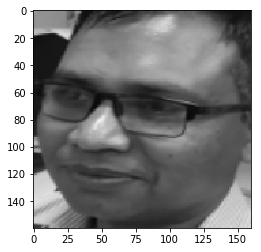

In [6]:
a, b = face_extract_dnn(to_rgb(cv2.imread('images/Train/Suresh/Suresh3.png')), 10, model=net)
plt.imshow(a)
print(b)
a.shape

(20, 15, 124, 146)


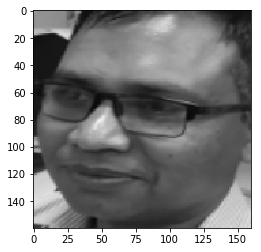

In [7]:
f, s = preprocess([imread('images/Train/Suresh/Suresh3.png')], 10)
print(s)
plt.imshow(f[0])

In [8]:
notDetected = list()
def loadRawOrderedData(dir_basepath, margin=10, augment_size = 0):
    names = os.listdir(dir_basepath)
    imgs = []
    labels = []
    nameDict = dict()
    for i in names:
        nameDict[hash(i)] = i
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)]
        for i in filepaths:
            _img = imread(i)
            imgs_, status = preprocess([_img], margin) 
            if status is False:
                #imgs_, status = AIengine.preprocess([imread(i)], cascade_path = './cv2/lbpcascade_profileface.xml') 
                if status is False:
                    print("No face detected in " + i)
                    notDetected.append(imgs_)
                    continue
                else: 
                    print("Detected hard image " + i)
            imgs.append(imgs_)
            labels.append(name)
            for j in range(0, augment_size):
                tmp = random_rotate_image(_img)
                im, status = preprocess([tmp], margin) 
                if status is not False:
                    imgs.append(im)
                    labels.append(name)
                else:
                    notDetected.append(im)
                    print("No face detected")
            # Augmented Data
        #labels.extend([name] * len(imgs_))
        #imgs.append(imgs_)
    imgs = np.concatenate(imgs)
    return imgs, labels, nameDict


def loadRawTestData(filepaths):
    imgs = [np.array(imread(i)) for i in filepaths]
    return np.array(imgs)

In [9]:
def loadRawYalesData(filepath):
    imgs = [np.array(imread(filepath + i)) for i in os.listdir(filepath)] 
    return np.array(imgs)

In [10]:

def validateSimilarity(uvecs, vec, k = 0.65):
    # Returns true if vec is similar to atleast 'k' fraction of vectors
    frac = round(k*len(uvecs))
    #results = [i for i in face_recognition.compare_faces(uvecs, vec) if i is True]#[np.linalg.norm(vec - i) for i in uvecs if np.linalg.norm(vec - i) <= 0.88]#distance.euclidean(i, vec) <= 0.88]
    #results = [np.linalg.norm(vec - i) for i in uvecs if np.linalg.norm(vec - i) <= 0.80]
    results = [distance.cosine(i, vec) for i in uvecs if distance.cosine(i, vec) <= 0.37]
    #print(results)
    print("Similar to " + str(len(results)) + " Photos of the person out of " + str(len(uvecs)))
    #print(results)
    print([distance.cosine(i, vec) for i in uvecs])
    if len(results) >= frac:
        return True 
    return False

In [11]:
cascade_path = './cv2/haarcascade_frontalface_alt2.xml'
image_dir_basepath = './images/'

train_dirpath = os.path.join(image_dir_basepath, 'Train/')

image_size = 160

In [208]:
# Load Raw Data
imgs, labels, nameDict = loadRawOrderedData(train_dirpath, augment_size=0)

In [209]:
imgs.shape

(102, 160, 160, 3)

In [171]:
plt.imshow(face_extract_dnn(to_rgb(test[0]), 10)[0])

NameError: name 'test' is not defined

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


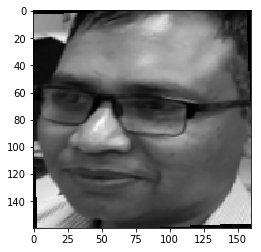

In [172]:
# Data Augmentation -->

# Random Rotation ->
rotated = [random_rotate_image(i) for i in imgs]
plt.imshow(rotated[0])

In [210]:
metadata = {'labelEncodeMap': {value: key for key,
                                       value in nameDict.items()}, 'labelDecodeMap': nameDict,
                         'imagesize': 160, 'similarity_margin': 10}

In [211]:
import pickle
f = open('./models/model_nostranger.meta', 'wb')
f.write(pickle.dumps(metadata))
f.close()

In [212]:
# Get Embeddings from the Data
embs, status = ai_engine.embed(imgs, preprocess = False)

X = np.array(embs)
Y = np.array([hash(i) for i in labels])
X, test_x, Y, test_y = train_test_split(X,Y,test_size=0)

In [213]:
print(Y.shape)
X.shape

(102,)


(102, 512)

In [214]:
Y[0]

5377809046654074286

In [215]:
# Create grouped object
vecDict = dict()
for i in labels:
    vecDict[i] = list()
for i in range(0, len(labels)):
    vecDict[labels[i]].append(embs[i])

In [217]:
# Save to JSON Document
import pickle
f = open('./models/vectormaps_nostranger.json', 'wb')
f.write(pickle.dumps(vecDict))
f.close()

In [228]:
# Our Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

classifier = SVC(kernel='linear', probability=True)#
#classifier = RandomForestClassifier()
#classifier = MLPClassifier()
#classifier = KNeighborsClassifier()

In [229]:
classifier.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [220]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_names = os.listdir(test_dirpath)
test_filepaths = [os.path.join(test_dirpath, f) for f in test_names]
test_labels = [i.split('.')[0] for i in test_names]
test_imgs = loadRawTestData(test_filepaths)
len(test_labels)

31

In [221]:
test_pre, status = preprocess(test_imgs)
test_vec, status = ai_engine.embed(test_pre, preprocess=False)
test_pre.shape


(31, 160, 160, 3)

In [222]:
pred = classifier.predict(test_vec)#infer(classifier, test_filepaths)
results = [(nameDict[i],j) for i,j in zip(pred,test_labels)]
#print(results)
pred_labels = [i[0] for i in results]
for i in results:
    print(i)

('Abhishek', 'Abhishek')
('Nikhil', 'Nikhil')
('Ashish', 'Ashish')
('Santosh', 'Santosh')
('Abhishek', 'Abhishek')
('Suresh', 'Suresh')
('LarryPage', 'LarryPage')
('AnthonyHopkins', 'AnthonyHopkins')
('Davinder', 'Davinder')
('CPSingh', 'CPSingh')
('Sonu', 'Sonu')
('Surya', 'Surya')
('Harendra', 'Harendra')
('Davinder', 'Davinder')
('CPSingh', 'CPSingh')
('Nagesh', 'Stranger')
('Suresh', 'Stranger')
('Santosh', 'Stranger')
('Davinder', 'Stranger')
('Dushyant', 'Dushyant')
('MarkZuckerberg', 'MarkZuckerberg')
('Aayushi', 'Aayushi')
('Pankaj', 'Pankaj')
('Jyoti', 'Jyoti')
('BillGates', 'BillGates')
('Harendra', 'Stranger')
('MarkZuckerberg', 'Stranger')
('Nagesh', 'Nagesh')
('Neha', 'Neha')
('Sonali', 'Sonali')
('Harvinder', 'Harvinder')


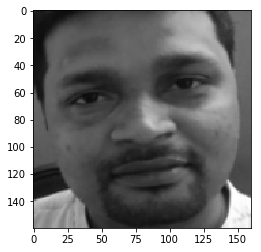

In [223]:
plt.imshow(imgs[5])
plt.show()

In [224]:
for i in results:
    if i[0] != i[1]:
        print("FOUND")
        print(i)

FOUND
('Nagesh', 'Stranger')
FOUND
('Suresh', 'Stranger')
FOUND
('Santosh', 'Stranger')
FOUND
('Davinder', 'Stranger')
FOUND
('Harendra', 'Stranger')
FOUND
('MarkZuckerberg', 'Stranger')


[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 

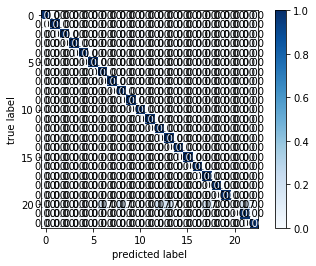

In [225]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [226]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

0.8064516129032258

In [230]:
# Save the model
f = open('./models/model_svm_NOstranger.pkl', 'wb')
f.write(pickle.dumps(classifier))
f.close()

In [203]:
# Check the effectiveness of Similarity matching
# We use yale dataset as a source of 'stranger' photos. Lets see what happens
 
yales_imgs = loadRawYalesData('./images/validate/')
yales_pre, status = preprocess(yales_imgs)
yales_labels = ['Stranger'] * len(yales_pre)
yales_embs, status = ai_engine.embed(yales_pre, preprocess=False)

In [204]:
print(yales_embs.shape)
print(test_vec.shape)
print(len(yales_labels))

(166, 512)
(31, 512)
166


In [205]:
val_embs = np.concatenate([yales_embs, test_vec])
val_labels = np.concatenate([yales_labels, test_labels])
pred_labels = list()
for i in val_embs:
    name = nameDict[classifier.predict([i])[0]]
    uvecs = vecDict[name]
    val = validateSimilarity(uvecs, i)
    if val is True:
        pred_labels.append(name)
    else:
        print("Person " + name + " Not recognized")
        pred_labels.append('Stranger')
        
results = [(i,j) for i,j in zip(pred_labels,val_labels)]

Similar to 10 Photos of the person out of 133
[0.021860897541046143, 1.2509048581123352, 0.919080413877964, 1.04949139803648, 1.1301628202199936, 1.0126287853345275, 0.9032213538885117, 1.16345776617527, 0.969229931011796, 0.3896613121032715, 0.9488336779177189, 0.9353840872645378, 1.033756598830223, 0.8399118632078171, 1.0253561437129974, 1.0152285266667604, 1.0250321440398693, 0.9211195781826973, 1.168329656124115, 1.0771366208791733, 0.9774702284485102, 1.040857020765543, 0.9218382015824318, 1.1652265340089798, 0.17234724760055542, 0.907092496752739, 1.1418650299310684, 0.1961769461631775, 1.1274687200784683, 0.9944529165513813, 0.9693294335156679, 1.078094758093357, 1.0492784976959229, 1.1823979169130325, 1.194524884223938, 1.0963669419288635, 1.1777600646018982, 1.1420353204011917, 0.7863095551729202, 1.0497672855854034, 1.006701656151563, 0.9795801136642694, 0.892762191593647, 1.2498141378164291, 0.9782515186816454, 0.9353182017803192, 0.8844616040587425, 1.0328978970646858, 1.05

[1.1379945278167725, 0.7233923971652985, 0.819662868976593, 0.3728102445602417, 0.015379190444946289, 0.95425209030509, 0.8347962200641632, 0.8828434646129608, 0.8307747840881348, 1.055810198187828, 1.0163545962423086, 0.9543515183031559, 0.759861409664154, 1.14090895652771, 0.9166284799575806, 1.0962929129600525, 1.068615846335888, 0.7850971519947052, 0.32005900144577026, 0.38641107082366943, 1.1544472873210907, 0.1983054280281067, 1.0950898304581642, 0.8613359332084656, 1.1932645291090012, 1.0143311899155378, 0.0904545783996582, 1.1301287412643433, 0.9540340974926949, 0.8204815089702606, 0.7844894230365753, 0.9138553589582443, 0.4362757205963135, 0.11029785871505737, 0.7315351665019989, 0.9839298874139786, 0.7959416508674622, 0.13238120079040527, 0.954628225415945, 0.8475009799003601, 0.8447936475276947, 0.8670594692230225, 0.992769431322813, 0.8765485137701035, 0.9558835998177528, 0.8049087673425674, 1.067898616194725, 0.9094731956720352, 1.1152028441429138, 0.8964807093143463, 1.00

Similar to 11 Photos of the person out of 133
[0.9693559966981411, 0.8010055124759674, 1.0155955590307713, 0.8197561204433441, 0.8777389600872993, 0.8137180209159851, 0.1771470308303833, 1.1167870089411736, 0.02418893575668335, 1.168774127960205, 0.8966079950332642, 0.11831820011138916, 0.9474852904677391, 0.9544345363974571, 0.570907473564148, 0.9568796381354332, 1.1033446341753006, 1.0773382261395454, 0.8503313660621643, 0.8547900766134262, 0.9234791621565819, 0.9496023654937744, 0.8837765902280807, 0.8173107504844666, 1.0878459513187408, 1.032769300043583, 0.8882357403635979, 1.0442008152604103, 0.8802209198474884, 0.04784595966339111, 0.9547740966081619, 1.255306452512741, 0.9213637411594391, 0.8986950442194939, 1.1407590806484222, 0.9255104288458824, 0.6768481135368347, 0.8970958143472672, 1.0530652776360512, 0.1974714994430542, 0.9284549951553345, 0.08005392551422119, 1.0338529720902443, 0.7273387312889099, 0.49638766050338745, 0.9734096489846706, 1.0948060750961304, 0.6463584303

Similar to 11 Photos of the person out of 133
[0.9489291682839394, 0.8509856313467026, 0.9247658774256706, 0.8619181215763092, 0.9573687352240086, 0.931481309235096, 0.19922220706939697, 1.1866568475961685, 0.0796540379524231, 1.1624553948640823, 0.9252159148454666, 0.014245867729187012, 0.8330392092466354, 0.9844778459519148, 0.6505419015884399, 0.9143513962626457, 1.0948930457234383, 1.1365931928157806, 0.9161878377199173, 0.9059282913804054, 0.9172218665480614, 1.0591743886470795, 0.9175024852156639, 0.8375944942235947, 1.019188655540347, 1.113290712237358, 0.9472089409828186, 1.066694550216198, 0.9261512830853462, 0.08384549617767334, 0.8774518147110939, 1.3031193315982819, 0.940035667270422, 0.9687141999602318, 1.197187751531601, 0.9876431673765182, 0.750205785036087, 0.9562942907214165, 1.1141909807920456, 0.17156332731246948, 0.8500945717096329, 0.0779808759689331, 0.9932827325537801, 0.8124007731676102, 0.5912406742572784, 1.018121985718608, 1.0771106481552124, 0.69021493196487

[1.00864998716861, 0.6159117221832275, 1.0629469156265259, 0.7156505882740021, 0.5265750586986542, 0.7102749049663544, 0.690100908279419, 0.9462369121611118, 0.6807675361633301, 1.0706128254532814, 0.9769046194851398, 0.8396376371383667, 1.0732619166374207, 0.9882141957059503, 0.8440447598695755, 1.1810143440961838, 1.205755576491356, 1.104045830667019, 0.6478573083877563, 0.6486776769161224, 0.8891433700919151, 0.5681959390640259, 0.9631614796817303, 0.7294626832008362, 1.1117244511842728, 1.0836511924862862, 0.5125720500946045, 0.9474283494055271, 0.8363600075244904, 0.6892646849155426, 1.0594919212162495, 0.961065374314785, 0.5911371409893036, 0.5755470991134644, 0.8955060765147209, 0.7922634780406952, 0.643746554851532, 0.4679661989212036, 1.0217379368841648, 0.8242730349302292, 1.1985022127628326, 0.802618145942688, 1.0080636581405997, 0.6638802289962769, 0.8228564560413361, 1.0682007148861885, 1.0659501180052757, 0.882172018289566, 1.1542330384254456, 1.1242918446660042, 0.771996

Similar to 0 Photos of the person out of 133
[1.1296798884868622, 0.7668644040822983, 0.9291147738695145, 0.6674079298973083, 0.673473447561264, 0.6891075968742371, 0.8293720781803131, 0.8204097002744675, 0.8448372334241867, 1.105931594967842, 0.6215102076530457, 0.866211548447609, 0.9082267805933952, 0.7908532470464706, 1.046618577092886, 0.9448602125048637, 0.8682073801755905, 1.1314878016710281, 0.6350550353527069, 0.5265072584152222, 0.8739328533411026, 0.8062866181135178, 0.6901355385780334, 0.7547473162412643, 1.1151795536279678, 1.1030788719654083, 0.7592843770980835, 1.1353533118963242, 0.7181455492973328, 0.8524481803178787, 0.9295193031430244, 0.8118402510881424, 0.6565849483013153, 0.8036038726568222, 0.7492780387401581, 0.6792862415313721, 0.7677262723445892, 0.8125838786363602, 1.0886897221207619, 0.8696773201227188, 0.9156777486205101, 0.8108449578285217, 0.594431608915329, 0.7794471085071564, 0.9433221481740475, 1.0692718848586082, 0.6819319427013397, 1.1478384286165237,

Similar to 9 Photos of the person out of 133
[0.2009250521659851, 1.1282077431678772, 0.8043380528688431, 1.1863279342651367, 1.214725211262703, 1.0125693110749125, 0.9409341402351856, 1.0684511810541153, 1.0851252302527428, 0.47216951847076416, 0.9104149639606476, 1.0359485149383545, 0.9472209513187408, 0.7856808304786682, 1.024688731878996, 1.0362413302063942, 0.9652723670005798, 1.0209483988583088, 1.301457166671753, 1.1669502407312393, 0.9438695535063744, 1.2025494128465652, 0.9064231291413307, 1.132513865828514, 0.044287145137786865, 0.9826691560447216, 1.1670078933238983, 0.3230433464050293, 1.0920205414295197, 1.0834058001637459, 0.8716368228197098, 0.9772479124367237, 1.1558690518140793, 1.2021382600069046, 1.1186345964670181, 1.0530383586883545, 1.0868771821260452, 1.2302942276000977, 0.8381803631782532, 1.1265940219163895, 0.9337684437632561, 1.0888337194919586, 0.9032375365495682, 1.1815306395292282, 0.9841884206980467, 1.0777701660990715, 0.86305932700634, 1.062877349555492

[1.0486342087388039, 0.48540133237838745, 0.8656983077526093, 0.9222427383065224, 0.7201590538024902, 1.019232340157032, 0.48334193229675293, 1.0366312265396118, 0.5433472096920013, 1.0560916140675545, 1.136915311217308, 0.6215113401412964, 0.842888206243515, 1.1181113123893738, 0.46160781383514404, 1.2591035068035126, 1.2384249120950699, 0.8477141559123993, 0.8954258263111115, 0.8965416103601456, 1.0384295731782913, 0.8147535175085068, 1.1816262006759644, 0.554657369852066, 1.013267632573843, 0.9515257328748703, 0.7687583565711975, 0.9456370770931244, 0.9407430365681648, 0.5520990788936615, 0.8876899629831314, 1.1428357362747192, 0.9309385418891907, 0.7423586249351501, 0.8960204944014549, 0.9278635829687119, 0.4455282688140869, 0.7838150560855865, 0.9668953344225883, 0.5074096918106079, 0.9387057013809681, 0.6025294065475464, 1.144286423921585, 0.5152139663696289, 0.4615846872329712, 0.8245457261800766, 1.201048344373703, 0.46836376190185547, 1.3568482398986816, 1.0283887777477503, 0.

[1.1690067201852798, 0.39100372791290283, 1.0529453419148922, 0.9238696619868279, 0.7039126455783844, 0.9938655770383775, 0.5997254848480225, 1.1303310692310333, 0.5725123286247253, 1.1140309423208237, 1.1147910207509995, 0.678135335445404, 1.0537230633199215, 1.1402642577886581, 0.449577271938324, 1.1391298323869705, 1.1928852051496506, 0.9727028142660856, 0.8148636072874069, 0.8234717398881912, 0.9708847422152758, 0.840163916349411, 1.1648759096860886, 0.4959442615509033, 1.1106224730610847, 1.1246253848075867, 0.7561644464731216, 0.9765087850391865, 0.8278306126594543, 0.601149708032608, 1.054505493491888, 1.2591203153133392, 0.8590391129255295, 0.6732130348682404, 0.968794196844101, 0.9293166026473045, 0.3856859803199768, 0.6969116926193237, 1.1566957384347916, 0.5629501342773438, 1.0904429778456688, 0.6364553570747375, 1.2130549997091293, 0.4332611560821533, 0.5204773843288422, 1.017378993332386, 1.2371817380189896, 0.4447590708732605, 1.3382806777954102, 1.1528253704309464, 0.874

Similar to 11 Photos of the person out of 133
[0.9927224759012461, 0.5910570621490479, 1.117268554866314, 1.0000706454738975, 1.0111704878509045, 0.23342084884643555, 0.9074753448367119, 0.5414133965969086, 0.9183254539966583, 1.0729777365922928, 0.9750062916427851, 1.0199004486203194, 1.1468262523412704, 0.8326021283864975, 0.9066781476140022, 0.9640549905598164, 0.9470642879605293, 1.1806835532188416, 0.9784197527915239, 0.9265945181250572, 0.2525596618652344, 0.9726591762155294, 0.9250997304916382, 0.6563372313976288, 0.9450719691812992, 0.9021693766117096, 0.9941163780167699, 0.9313254654407501, 0.177443265914917, 0.9556532427668571, 1.1472613662481308, 0.7419551014900208, 0.9872316513210535, 1.0648515075445175, 0.5964379906654358, 0.024156272411346436, 0.5657185018062592, 1.0320741161704063, 0.9664627388119698, 1.00343400076963, 1.0375862419605255, 0.8756849616765976, 1.1475090980529785, 0.5342328548431396, 0.9519159458577633, 1.1762709021568298, 1.0300391614437103, 0.944700706750

Similar to 11 Photos of the person out of 133
[0.998507376643829, 1.1649457216262817, 0.17553746700286865, 0.9990866165608168, 0.853042334318161, 1.029851522296667, 0.9711492918431759, 0.7375631928443909, 0.9112709015607834, 0.9994698967784643, 0.856941357254982, 0.8550333231687546, 0.12172329425811768, 0.9927603099495173, 0.8356767892837524, 0.7374287545681, 0.6730543971061707, 0.8747220635414124, 1.1237850189208984, 1.1691744774580002, 1.0677552819252014, 0.8819640278816223, 0.8618453145027161, 1.0900465175509453, 0.9128693416714668, 0.8263965547084808, 0.7649649083614349, 1.0852251127362251, 1.1424417048692703, 0.9117868468165398, 0.1654888391494751, 0.7376942038536072, 1.1597662568092346, 0.8503007888793945, 0.7271979749202728, 1.0272312387824059, 1.1219262406229973, 0.9021738618612289, 0.757529228925705, 0.8739882558584213, 0.02050185203552246, 0.8642204701900482, 0.83431676030159, 1.2070078700780869, 0.8154485821723938, 0.7766873836517334, 0.808064192533493, 0.8147563487291336, 0

Similar to 11 Photos of the person out of 133
[1.0096681797876954, 0.6955752372741699, 0.9806759301573038, 0.7845465838909149, 0.9322094693779945, 0.8765093460679054, 0.6401273310184479, 0.9896788643673062, 0.5352951884269714, 1.1498787999153137, 0.9969055643305182, 0.6394893229007721, 0.887699231505394, 1.1558688431978226, 0.11601269245147705, 0.9560563750565052, 1.0304695460945368, 1.0324977971613407, 0.809801310300827, 0.8637863099575043, 0.9215553998947144, 0.9973492508288473, 1.1458252519369125, 0.7771211415529251, 1.0507823377847672, 1.0798906162381172, 0.9582313038408756, 1.049299519509077, 0.9312434419989586, 0.5481816530227661, 0.9018813446164131, 1.0078449780121446, 0.8188192695379257, 0.9245138391852379, 0.8202834129333496, 0.981337608769536, 0.6265370845794678, 1.0094840098172426, 1.103852204978466, 0.6257993280887604, 0.8681933432817459, 0.5816349685192108, 1.1370287984609604, 0.713566929101944, 0.017227113246917725, 0.9851992791518569, 1.1365008801221848, 0.16992789506912

[1.1038950309157372, 0.6248931586742401, 1.1234547719359398, 0.9904529079794884, 1.0644114166498184, 0.09131771326065063, 0.8397397696971893, 0.5762349367141724, 0.8094587028026581, 1.1925273537635803, 1.0107845850288868, 0.9102321937680244, 1.1471128016710281, 0.8855257853865623, 0.7927743643522263, 0.8310623914003372, 0.7950097918510437, 1.126639261841774, 1.0468028634786606, 0.9298532530665398, 0.14578229188919067, 1.0250145848840475, 0.9804888125509024, 0.6660903990268707, 1.0055591412819922, 0.8907779157161713, 1.0163070820271969, 0.9374838843941689, 0.15558010339736938, 0.8256066888570786, 1.1591934114694595, 0.820812851190567, 1.01180574670434, 1.124071441590786, 0.6293019652366638, 0.1945696473121643, 0.5507496297359467, 1.0833335295319557, 0.9665062353014946, 0.8778638020157814, 1.013741821050644, 0.7376008033752441, 1.2170126736164093, 0.5748692154884338, 0.851850837469101, 1.112615443766117, 1.0616983622312546, 0.8439513295888901, 0.991233479231596, 1.0149647444486618, 0.014

Similar to 12 Photos of the person out of 133
[0.17878156900405884, 1.1215882897377014, 1.048604790121317, 1.1477987170219421, 1.1879698932170868, 0.9164413213729858, 0.9832989182323217, 1.212432712316513, 1.0431607104837894, 0.2856528162956238, 1.1326994448900223, 1.0673348680138588, 1.0865667164325714, 1.0408698916435242, 1.0177625808864832, 1.155830293893814, 1.0468634217977524, 0.9166225865483284, 1.2209697663784027, 1.1670433729887009, 0.8292404115200043, 1.0442512780427933, 1.0980620831251144, 1.0402162931859493, 0.24359411001205444, 0.9205958470702171, 1.2190138101577759, 0.08579576015472412, 1.053284965455532, 1.0669874176383018, 1.0198691058903933, 1.1740060150623322, 1.180125281214714, 1.2487522065639496, 1.2537469863891602, 1.0121284425258636, 1.0489457733929157, 1.1989463865756989, 0.8328886032104492, 1.1227093786001205, 1.0563073754310608, 1.0794688761234283, 1.1124621480703354, 1.0995289161801338, 0.9843021780252457, 0.9547550529241562, 1.0607666857540607, 1.0316643752157

[0.9989500640658662, 0.7873762845993042, 0.9373530596494675, 0.8536492437124252, 0.8886156752705574, 0.9135431423783302, 0.23444032669067383, 1.255949318408966, 0.16030722856521606, 1.033580083400011, 0.9171239212155342, 0.163100004196167, 0.9597085863351822, 0.9112446755170822, 0.6910994946956635, 0.8234688341617584, 0.9742315653711557, 0.9778224285691977, 0.8710411190986633, 0.8496584594249725, 0.8829385712742805, 0.9951241291128099, 0.8714619427919388, 0.7252640426158905, 0.9975450185593218, 1.0841268226504326, 0.8649720996618271, 1.0085933720692992, 0.8295645266771317, 0.1847447156906128, 0.9387683682143688, 1.4226495921611786, 0.9520332179963589, 0.8548458367586136, 1.2323409020900726, 0.959219440817833, 0.6935729086399078, 0.9245760664343834, 1.0769053772091866, 0.18504118919372559, 0.9256805330514908, 0.14468026161193848, 1.0330655239522457, 0.6990673542022705, 0.6816856563091278, 0.9600226916372776, 1.0476910211145878, 0.6954484283924103, 1.0312269162386656, 0.9077475890517235,

[0.8863833248615265, 1.0771403163671494, 0.795422837138176, 0.9474548287689686, 0.9932377682998776, 0.8635279387235641, 0.9799268953502178, 0.8875658437609673, 0.8978678360581398, 1.0808718651533127, 0.16466325521469116, 0.857330858707428, 0.8823571652173996, 0.21556788682937622, 1.1119623184204102, 0.6131516695022583, 0.6672593653202057, 1.0997198596596718, 1.0226274821907282, 0.8613615185022354, 1.0170115437358618, 0.9970617152284831, 0.053254663944244385, 1.1038332358002663, 0.9229072108864784, 1.014004597440362, 0.9625327326357365, 1.137178584933281, 0.9748630058020353, 0.9158448204398155, 0.7675347775220871, 0.7827687114477158, 0.869858518242836, 0.9106739982962608, 0.9058399870991707, 0.9941421444527805, 1.0842713937163353, 0.968724824488163, 0.9598624147474766, 0.8586234748363495, 0.8817422315478325, 0.8462398201227188, 0.2307031750679016, 1.0343977026641369, 1.0651763007044792, 1.0794994533061981, 0.2191981077194214, 1.1569973975419998, 0.6609949469566345, 0.8008120059967041, 0

[1.057971440255642, 0.6569347679615021, 1.2231632471084595, 0.9974162534344941, 1.0049338331446052, 0.2473759651184082, 0.9132312387228012, 0.7472507655620575, 0.9060654044151306, 1.1764415949583054, 0.9745126441121101, 0.9666578508913517, 1.1853916496038437, 0.9801997542381287, 0.9015110731124878, 1.012841496616602, 0.9581669420003891, 1.093891590833664, 1.0103070912882686, 0.9418458938598633, 0.27365773916244507, 0.9650621563196182, 1.001216675969772, 0.6107728481292725, 1.020261999219656, 0.9107770696282387, 0.9663210175931454, 0.9835817459970713, 0.09638082981109619, 0.9330113977193832, 1.2104627639055252, 0.8462913185358047, 1.02724264934659, 1.0245118848979473, 0.7208064496517181, 0.2499414086341858, 0.5768082141876221, 1.0580019727349281, 0.9722890742123127, 0.9322734177112579, 1.0583864599466324, 0.8294777721166611, 1.2196256518363953, 0.6364864110946655, 0.9330316409468651, 1.056337121874094, 1.0136338341981173, 0.8944613486528397, 1.0990914553403854, 1.119255244731903, 0.2173

[1.132768139243126, 0.6138758659362793, 1.188572034239769, 0.973866131156683, 1.0184218622744083, 0.08931142091751099, 0.877834290266037, 0.5916503071784973, 0.843112513422966, 1.2217881977558136, 0.9157474860548973, 0.9614127837121487, 1.2027239352464676, 0.8816410303115845, 0.7848633527755737, 0.9261141270399094, 0.855550616979599, 1.1659397333860397, 1.0065950388088822, 0.8798795565962791, 0.2036200761795044, 1.0025351587682962, 0.9238000512123108, 0.6603648960590363, 1.0533858612179756, 0.9308033883571625, 0.98524652980268, 0.9747292939573526, 0.16222995519638062, 0.8642834275960922, 1.2076140344142914, 0.7892255783081055, 0.9470208436250687, 1.051283523440361, 0.595001220703125, 0.19338703155517578, 0.5700422823429108, 1.0434644594788551, 0.9834155738353729, 0.9458606950938702, 1.0629189535975456, 0.77845698595047, 1.1639859527349472, 0.5415992140769958, 0.8303488492965698, 1.1510966122150421, 1.0214757397770882, 0.8368159681558609, 1.0186996161937714, 1.0605518817901611, 0.069000

Similar to 1 Photos of the person out of 133
[0.9549089595675468, 0.6516644358634949, 0.8279047757387161, 0.9751711115241051, 0.8343746066093445, 1.0078503843396902, 0.5978086292743683, 1.0277845486998558, 0.5648852586746216, 1.0405745096504688, 0.9150873124599457, 0.6091527044773102, 0.7478338778018951, 1.0017238352447748, 0.47391247749328613, 1.2048961371183395, 1.1296341717243195, 0.6863137781620026, 1.0180915854871273, 0.9889997160062194, 1.1204306930303574, 0.9240798205137253, 1.0011633429676294, 0.6408950388431549, 1.025212462991476, 0.7517681270837784, 0.8890093564987183, 0.9186844676733017, 1.0109050143510103, 0.5986932814121246, 0.804914265871048, 1.0414783209562302, 1.0625617504119873, 0.889708623290062, 0.9291151762008667, 1.0406432524323463, 0.602690190076828, 0.9434028826653957, 0.7719744145870209, 0.5031099915504456, 0.8282772600650787, 0.6295472085475922, 0.9130823686718941, 0.7043235003948212, 0.4142504930496216, 0.6095617711544037, 0.9575910940766335, 0.473197638988494

[0.9992262320010923, 0.86112180352211, 1.028065089136362, 0.8222135454416275, 0.8690970093011856, 0.8215258419513702, 0.1433507800102234, 1.1150553822517395, 0.02379477024078369, 1.1679512858390808, 0.9740301482379436, 0.11101347208023071, 0.9477353692054749, 1.0199803803116083, 0.6122483313083649, 0.9977557212114334, 1.128033608198166, 1.0730182901024818, 0.8596161454916, 0.8700098991394043, 0.9146551340818405, 0.954816672950983, 0.9555926509201527, 0.8612360209226608, 1.0929633900523186, 1.0244638435542583, 0.8751443028450012, 1.0655113533139229, 0.9154544472694397, 0.019336342811584473, 0.9660951420664787, 1.2487399280071259, 0.9385320357978344, 0.8885827660560608, 1.144455149769783, 0.9548827037215233, 0.724832683801651, 0.8860772103071213, 1.0472980737686157, 0.1979759931564331, 0.9418702982366085, 0.0690617561340332, 1.096313439309597, 0.7760868519544601, 0.5449095666408539, 0.9753678422421217, 1.1629887968301773, 0.6761924922466278, 1.107754573225975, 0.9051052406430244, 0.86936

Similar to 11 Photos of the person out of 133
[0.9552088193595409, 1.0567524135112762, 0.8672799617052078, 0.8674695193767548, 0.915762685239315, 0.8840138539671898, 0.8766914904117584, 0.8911182209849358, 0.7846552282571793, 1.2320314943790436, 0.19065546989440918, 0.762419119477272, 0.8935005068778992, 0.2784242630004883, 1.1234949380159378, 0.6537579596042633, 0.762920543551445, 1.1904886811971664, 0.925533726811409, 0.7788011282682419, 1.029965166002512, 0.9610128961503506, 0.1171194314956665, 1.1149906069040298, 1.0408399440348148, 1.0941076055169106, 0.9264031127095222, 1.2605419754981995, 0.9553052298724651, 0.7948286384344101, 0.8151166886091232, 0.780645102262497, 0.802500531077385, 0.8532784134149551, 0.923576831817627, 0.992650035303086, 1.070697233080864, 0.9058751165866852, 1.0516309030354023, 0.79550901055336, 0.9082817882299423, 0.7288453578948975, 0.24867123365402222, 1.039985354989767, 1.068204440176487, 1.119006022810936, 0.26018059253692627, 1.1656682789325714, 0.774

Similar to 11 Photos of the person out of 133
[0.9963703339453787, 1.337616205215454, 0.7773801982402802, 0.9681922271847725, 1.1417120695114136, 0.9361552596092224, 1.2243938148021698, 0.8730014264583588, 1.105114832520485, 1.002054262906313, 0.8490438759326935, 1.0172526147216558, 0.8646887987852097, 0.7584487497806549, 1.0509834475815296, 0.18004769086837769, 0.18703579902648926, 1.148154854774475, 1.0568278171122074, 0.9970195104833692, 1.0143495295196772, 1.1923303604125977, 0.6721427142620087, 1.1378656476736069, 0.9511168338358402, 1.0088423881679773, 1.0284115765243769, 1.123198926448822, 1.0491835922002792, 1.0907266214489937, 0.7994333803653717, 0.9072361290454865, 0.9343910217285156, 1.0747213661670685, 0.8875291496515274, 1.0502689816057682, 1.2786350846290588, 1.1244033575057983, 0.998820137232542, 1.0736588761210442, 0.7285712361335754, 1.0275680404156446, 0.7479829788208008, 1.2262548804283142, 1.065543569624424, 1.1964101046323776, 0.7855970859527588, 1.0914587900042534

[0.9372523352503777, 1.3084587156772614, 0.7022175490856171, 0.9767307452857494, 1.1625827252864838, 1.0265302769839764, 1.1541935503482819, 0.8428172618150711, 1.1231463924050331, 0.9226236045360565, 0.8831915035843849, 1.0346381068229675, 0.8304333984851837, 0.7304839789867401, 1.0864660665392876, 0.21641594171524048, 0.18900251388549805, 1.0562485456466675, 1.0297117475420237, 1.021150028333068, 1.0487585701048374, 1.2245577424764633, 0.6787388622760773, 1.1335761547088623, 0.8509656935930252, 0.9709363151341677, 1.0809430554509163, 1.0956488326191902, 1.133078783750534, 1.102135919034481, 0.7535712718963623, 0.8857505321502686, 0.9535757265985012, 1.1121884658932686, 0.8962742313742638, 1.0371994115412235, 1.2483314722776413, 1.1804801523685455, 0.946069061756134, 1.0472246706485748, 0.7097637355327606, 1.0272595416754484, 0.7792791575193405, 1.1871973723173141, 1.0657664313912392, 1.1212505549192429, 0.8155542016029358, 1.1113773509860039, 0.14102357625961304, 0.6104724705219269, 

Similar to 11 Photos of the person out of 133
[0.7366386353969574, 1.3201772570610046, 0.7533301264047623, 1.089689314365387, 0.869084358215332, 0.8782463669776917, 0.8473699390888214, 0.9801671374589205, 0.9954991694539785, 0.8503605276346207, 1.01860517449677, 1.0250443946570158, 0.816277265548706, 0.9759243167936802, 1.0822160840034485, 1.052031747996807, 0.9560666717588902, 0.33371371030807495, 1.2105370163917542, 1.2273899763822556, 1.0140931587666273, 0.887577086687088, 0.937558226287365, 1.1197937056422234, 0.839908093214035, 0.14859914779663086, 0.844539225101471, 0.8102208375930786, 0.9964417964220047, 0.9899854315444827, 0.8197950720787048, 0.9650390669703484, 1.1484141647815704, 0.9118798077106476, 1.0227028038352728, 0.9863291271030903, 1.1678533405065536, 0.8646206855773926, 0.08870625495910645, 0.9403899945318699, 0.7884310483932495, 1.0091104675084352, 0.9830156061798334, 1.2704285681247711, 1.0980193316936493, 0.2395564317703247, 1.0133803635835648, 1.0855554640293121, 

Similar to 11 Photos of the person out of 133
[1.0530960336327553, 0.6989704668521881, 0.8358089774847031, 0.5486238896846771, 0.149278461933136, 1.0618796944618225, 0.833926647901535, 0.8885194510221481, 0.9228162541985512, 0.879732072353363, 1.1262840628623962, 0.980178190395236, 0.8627106994390488, 1.067758597433567, 1.0329398699104786, 1.1325785964727402, 1.1075877323746681, 0.7673196494579315, 0.4910869598388672, 0.5543728172779083, 1.1073243021965027, 0.29736262559890747, 1.1297779828310013, 0.8287406414747238, 1.015057060867548, 1.0195673611015081, 0.23298269510269165, 1.0047202766872942, 1.0089739598333836, 0.9146202579140663, 0.8642905354499817, 1.0355342291295528, 0.5616481006145477, 0.18959611654281616, 0.8267484903335571, 0.9957100851461291, 0.7781216651201248, 0.25049614906311035, 0.9847571579739451, 0.9066964164376259, 0.9455326236784458, 0.9690394662320614, 1.0208153668791056, 0.8265774101018906, 1.086368441581726, 0.8351890742778778, 1.1303042620420456, 1.00644882349297

Similar to 11 Photos of the person out of 133
[1.1478037387132645, 0.1803721785545349, 0.9803900253027678, 0.9739429075270891, 0.928242415189743, 0.7142406105995178, 0.7039908468723297, 0.9395961500704288, 0.6733801662921906, 1.0181949473917484, 0.9895492037758231, 0.770873636007309, 1.0453003980219364, 0.9253038242459297, 0.7022729516029358, 1.0323090180754662, 1.0358447656035423, 1.1819364875555038, 0.8442615270614624, 0.8005308657884598, 0.7436160445213318, 0.9439134523272514, 0.9434081837534904, 0.13885265588760376, 1.0782537385821342, 1.1799505949020386, 0.9253640174865723, 1.0056210183538496, 0.6221539676189423, 0.7118466198444366, 1.076815403997898, 1.1380866765975952, 0.8064653724431992, 0.9471610896289349, 0.8905084133148193, 0.5203332602977753, 0.1310696005821228, 0.9547619372606277, 1.1890379041433334, 0.7536033987998962, 1.006713239941746, 0.7327944934368134, 1.1502084583044052, 0.11474114656448364, 0.6510234177112579, 1.194380447268486, 1.0862547233700752, 0.72245642542839

[1.2172240316867828, 0.15310466289520264, 1.1313653588294983, 0.9925742223858833, 0.9291703328490257, 0.7364794611930847, 0.7959470748901367, 0.917984738945961, 0.7828924655914307, 1.039755653589964, 1.0814096480607986, 0.8860480189323425, 1.2289526462554932, 0.9440009705722332, 0.778296023607254, 1.1002287343144417, 1.168411299586296, 1.2502326965332031, 0.7922489941120148, 0.7292251586914062, 0.7419721782207489, 0.9152836203575134, 1.005617855116725, 0.17291313409805298, 1.1613120585680008, 1.2732621133327484, 0.9359438270330429, 1.089580625295639, 0.5902536511421204, 0.8089943826198578, 1.2322996854782104, 1.0925019904971123, 0.7569328844547272, 0.9579375311732292, 0.8626092076301575, 0.5412082672119141, 0.18011802434921265, 0.9423023834824562, 1.3097898960113525, 0.8655548691749573, 1.2060887217521667, 0.8496214002370834, 1.1950750201940536, 0.0181577205657959, 0.7909489125013351, 1.302160620689392, 1.181823581457138, 0.7866076827049255, 1.238853007555008, 1.280082792043686, 0.6085

[1.014159383252263, 1.0641232281923294, 0.8161426037549973, 0.899649515748024, 0.8177594542503357, 0.6609743237495422, 1.1678815484046936, 0.2747977375984192, 1.245047315955162, 1.0349145978689194, 0.8537991940975189, 1.304507851600647, 0.9615250043570995, 0.9840374924242496, 0.9678858779370785, 0.7798809856176376, 0.7721081078052521, 1.00152730953414, 0.845012366771698, 0.8792836293578148, 0.7626594007015228, 0.7666550576686859, 0.9388147108256817, 1.0998030081391335, 0.997578154085204, 1.0508482716977596, 0.7668918371200562, 1.0929191783070564, 0.6337146461009979, 1.2445371001958847, 0.8856735080480576, 0.2865530848503113, 0.8942621648311615, 0.8398358821868896, 0.25000524520874023, 0.6279539167881012, 1.1026403084397316, 0.9389023035764694, 1.081573761999607, 1.2298638075590134, 0.8745341747999191, 1.2160305380821228, 0.9401602037250996, 1.0361485555768013, 1.0507722571492195, 1.040049236267805, 0.7909548580646515, 0.9597674757242203, 0.8872336000204086, 0.9169970154762268, 0.690953

Similar to 11 Photos of the person out of 133
[1.1407691538333893, 0.17435884475708008, 1.0304877534508705, 0.9703555982559919, 0.9488891959190369, 0.7764413803815842, 0.6897470355033875, 0.8823064640164375, 0.6822952628135681, 1.0524487607181072, 0.9267615377902985, 0.7438519895076752, 1.0500740259885788, 0.9117243066430092, 0.696931779384613, 1.08828055113554, 1.1367921233177185, 1.2223539501428604, 0.8694756627082825, 0.8034223765134811, 0.7771661579608917, 0.9973877221345901, 0.9025391936302185, 0.20761364698410034, 1.0626093447208405, 1.2731179296970367, 0.9777904786169529, 1.0278042405843735, 0.6998144388198853, 0.7151234745979309, 1.1001661494374275, 1.0569824948906898, 0.8264782279729843, 0.9942809734493494, 0.83196821808815, 0.6327812075614929, 0.16350799798965454, 1.0440109930932522, 1.2762334942817688, 0.7775382399559021, 1.074456699192524, 0.7295111417770386, 0.9918796122074127, 0.19378399848937988, 0.6490618288516998, 1.1703625619411469, 1.0142809245735407, 0.7664228826761

[1.082359917461872, 0.6627156734466553, 1.1737044304609299, 0.13660764694213867, 0.40718990564346313, 0.9151170179247856, 0.9059946909546852, 1.0222716256976128, 0.8084220588207245, 1.0328899435698986, 0.8864419460296631, 0.9220993742346764, 1.1569373905658722, 0.9376411624252796, 0.8364727050065994, 0.8003513962030411, 0.9224628880620003, 1.0906559154391289, 0.10159611701965332, 0.031811654567718506, 1.047323226928711, 0.5358312726020813, 0.95809256285429, 0.8047134876251221, 1.2047111541032791, 1.338723361492157, 0.5292990803718567, 1.1525842100381851, 0.9018573015928268, 0.7955290228128433, 1.108430527150631, 1.0352056622505188, 0.1340773105621338, 0.5045316219329834, 0.9053472876548767, 0.9796594940125942, 0.7422885000705719, 0.4184490442276001, 1.3067706823349, 0.781506285071373, 1.226751908659935, 0.8176099359989166, 0.8900700658559799, 0.7012921273708344, 0.8009210079908371, 1.1669290363788605, 1.01542017608881, 0.8833373561501503, 0.9594735205173492, 1.1984509527683258, 0.92185

[0.8021573722362518, 0.6274883151054382, 0.8555596321821213, 0.8191152065992355, 0.6856893002986908, 0.6799487769603729, 0.5888622403144836, 0.9133843258023262, 0.6500264704227448, 0.911354124546051, 0.9570599757134914, 0.752334251999855, 1.0243074353784323, 0.8296428769826889, 0.7664581388235092, 1.0405827313661575, 1.1564498990774155, 0.9741375166922808, 0.7776586413383484, 0.7230022847652435, 0.779896154999733, 0.7019334435462952, 0.8920496329665184, 0.699272871017456, 0.81711445748806, 1.0295408461242914, 0.6568109095096588, 0.7434866428375244, 0.7188412845134735, 0.7020240724086761, 0.9392577037215233, 1.010771724395454, 0.7426089942455292, 0.7211330831050873, 0.9105094745755196, 0.7116802632808685, 0.6452987492084503, 0.6627016961574554, 0.9482953883707523, 0.7162918746471405, 1.0903825834393501, 0.7558039277791977, 1.0094307884573936, 0.607026070356369, 0.805013582110405, 1.0092361122369766, 0.9989599556429312, 0.7856364101171494, 1.2398385256528854, 1.0129678333178163, 0.692549

Similar to 0 Photos of the person out of 133
[1.0300115533173084, 0.5943095088005066, 0.8761645182967186, 0.8725448250770569, 0.769327700138092, 0.8679812699556351, 0.48329102993011475, 0.931017592549324, 0.4887966513633728, 1.0326232835650444, 1.0280176028609276, 0.5514383316040039, 0.807422086596489, 1.072132132947445, 0.4856272339820862, 1.1985873132944107, 1.0978910699486732, 0.7008318305015564, 0.9343138113617897, 0.9448147714138031, 0.9412716068327427, 0.9088855162262917, 1.0929279923439026, 0.5732283890247345, 1.076433189213276, 0.7194561064243317, 0.8246298283338547, 0.917849712073803, 0.888788603246212, 0.507324606180191, 0.8686419129371643, 1.0558502860367298, 0.9985661989776418, 0.8359844535589218, 0.8799007758498192, 0.8790266290307045, 0.5183282196521759, 0.9087005853652954, 0.7654052823781967, 0.4501355290412903, 0.8736260682344437, 0.5465246737003326, 1.008871866390109, 0.6559098064899445, 0.42802757024765015, 0.6286176443099976, 1.1107654571533203, 0.5057371854782104, 1

Similar to 0 Photos of the person out of 133
[0.8716247528791428, 0.7105036377906799, 0.8200956135988235, 0.8778362199664116, 0.589690089225769, 0.6361390650272369, 0.633449137210846, 0.889877088367939, 0.6792486906051636, 0.9224184453487396, 0.9396888017654419, 0.8070454150438309, 0.9181583821773529, 0.824262261390686, 0.8325868844985962, 1.0398185662925243, 1.1020248755812645, 0.9228250160813332, 0.8340714126825333, 0.8140842765569687, 0.7342367470264435, 0.5362175107002258, 0.8715752959251404, 0.807751014828682, 0.8593914657831192, 0.9410032331943512, 0.5195283889770508, 0.8086219727993011, 0.6866652369499207, 0.7250204384326935, 0.8627603352069855, 0.9897277858108282, 0.8255240619182587, 0.601600855588913, 0.9073735773563385, 0.6728278696537018, 0.7238819301128387, 0.5535341203212738, 0.8898886144161224, 0.7338792979717255, 0.9950115326792002, 0.7719942927360535, 0.9885482424870133, 0.6926523745059967, 0.885297566652298, 0.9357650727033615, 0.9481874294579029, 0.8153197318315506, 1

Similar to 0 Photos of the person out of 133
[1.057002518326044, 0.6661761105060577, 0.8661932647228241, 0.7262764275074005, 0.6309245824813843, 0.6573477983474731, 0.8042780309915543, 0.7819747626781464, 0.8613106310367584, 1.023253683000803, 0.6364079117774963, 0.9214467704296112, 0.8703291714191437, 0.7487150728702545, 0.9679739885032177, 0.9561618492007256, 0.8765437006950378, 1.0359560288488865, 0.6727326214313507, 0.5806050002574921, 0.7970323264598846, 0.7376136183738708, 0.7137149572372437, 0.7181592285633087, 1.0060347598046064, 1.007615095935762, 0.7087131142616272, 1.0520336478948593, 0.6336306631565094, 0.8854395896196365, 0.8891227096319199, 0.7781166136264801, 0.6829542219638824, 0.7371632158756256, 0.6993227005004883, 0.5674835443496704, 0.6577461063861847, 0.7844079732894897, 0.9952945313416421, 0.9187877774238586, 0.871602937579155, 0.8410635590553284, 0.6747989058494568, 0.6782005131244659, 0.8785019889473915, 1.03573651984334, 0.706968367099762, 1.0608865767717361, 0

In [206]:
print(pred_labels)

['Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'St

FOUND
('Stranger', 'CPSingh')
[[  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0]


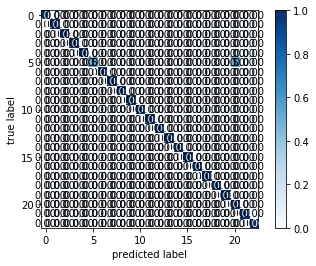

In [207]:
for i in results:
    if i[0] != i[1]:
        print("FOUND")
        print(i)
        
cm = sklearn.metrics.confusion_matrix(val_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [143]:
results

[('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 

In [144]:
print(test_labels[6], pred_labels[6])

LarryPage Stranger


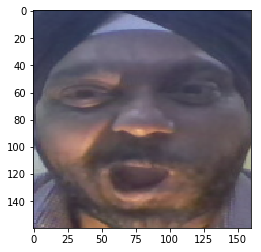

In [83]:
plt.imshow(test_pre[14])

In [38]:
test_labels[:5]

['Abhishek', 'Nikhil', 'Ashish', 'Santosh', 'Abhishek']

In [39]:
json.loads(a.text)

NameError: name 'json' is not defined

In [16]:
import requests as re
import json
import pickle

In [29]:
train_x, test_x, train_y, test_y = train_test_split(imgs,labels,test_size=0)

In [47]:
train_y[10:20]

['Harendra',
 'Neha',
 'Suresh',
 'Jyoti',
 'Harvinder',
 'Nikhil',
 'AnthonyHopkins',
 'Jyoti',
 'Sonali',
 'Harendra']

In [39]:
test_labels

['Abhishek',
 'Nikhil',
 'Ashish',
 'Santosh',
 'Abhishek',
 'Suresh',
 'LarryPage',
 'AnthonyHopkins',
 'Davinder',
 'Sonu',
 'Surya',
 'Harendra',
 'Davinder',
 'CPSingh',
 'Dushyant',
 'MarkZuckerberg',
 'Aayushi',
 'Pankaj',
 'Jyoti',
 'BillGates',
 'Nagesh',
 'Neha',
 'Sonali',
 'Harvinder']

In [42]:
pred_labels

['Abhishek',
 'Neha',
 'Surya',
 'Santosh',
 'Abhishek',
 'Suresh',
 'BillGates',
 'AnthonyHopkins',
 'Davinder',
 'Suresh',
 'Surya',
 'Neha',
 'BillGates',
 'Surya',
 'Dushyant',
 'BillGates',
 'Neha',
 'Santosh',
 'Neha',
 'Dushyant',
 'Abhishek',
 'Neha',
 'Neha',
 'Neha']

In [52]:
c = [i for i,j in zip(pred_labels, test_labels) if i == j]
print(c)
print(len(c))
print(len(c)/len(pred_labels))

['Nikhil', 'Suresh', 'AnthonyHopkins', 'Harendra', 'Jyoti', 'Neha', 'Sonali', 'Harvinder']
8
0.3333333333333333


In [97]:
test_imgs[0].dtype == 'float'

False

In [36]:
preprocess([i for i in test_imgs])

array([[[[0.87120481, 0.87120481, 0.87120481],
         [0.87131204, 0.87131204, 0.87131204],
         [0.87463235, 0.87463235, 0.87463235],
         ...,
         [0.99203431, 0.99203431, 0.99203431],
         [0.99239047, 0.99239047, 0.99239047],
         [0.99571461, 0.99571461, 0.99571461]],

        [[0.8884689 , 0.8884689 , 0.8884689 ],
         [0.89157858, 0.89157858, 0.89157858],
         [0.89522059, 0.89522059, 0.89522059],
         ...,
         [0.98860294, 0.98860294, 0.98860294],
         [0.98863741, 0.98863741, 0.98863741],
         [0.9889591 , 0.9889591 , 0.9889591 ]],

        [[0.89693627, 0.89693627, 0.89693627],
         [0.90036765, 0.90036765, 0.90036765],
         [0.90404412, 0.90404412, 0.90404412],
         ...,
         [0.99433594, 0.99433594, 0.99433594],
         [0.99185432, 0.99185432, 0.99185432],
         [0.99474954, 0.99474954, 0.99474954]],

        ...,

        [[0.08212699, 0.08212699, 0.08212699],
         [0.0758004 , 0.0758004 , 0.0758004 ]

In [17]:
# Create Model
t = re.post("http://localhost:5000/create", data=json.dumps({'user':'ashish'}))

In [128]:
a = re.post("http://localhost:5000/classify", data=json.dumps({'preprocess':True, 'data':[i.tolist() for i in test_imgs], 'user':'ashish', 'type':'img'}))
#[i.tolist() for i in test_imgs[:5]]
#test_imgs.tolist()
pred_labels = json.loads(a.text)

In [53]:
t = re.post("http://localhost:5000/train", data=json.dumps({'preprocess':False, 'data':train_x.tolist(), 'user':'ashish', 'type':'img', 'labels':train_y}))

In [26]:
g = np.array(imgs[:2].tolist())
g.shape

(2, 160, 160, 3)

In [23]:
t = re.post("http://localhost:5000/similarity", data=json.dumps({'img':imgs[1].tolist(), 'data':imgs[7].tolist(), 'user':'help', 'type':'img'}))

In [35]:
a.shape

(12, 512)

In [32]:
a.text

'["AnthonyHopkins"]\n'

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0

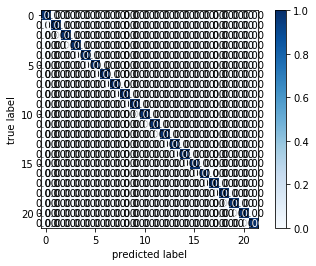

In [126]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [56]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

1.0

In [41]:
del model

In [49]:
import sys
from __future__ import print_function  # for Python2
l = list()
for var, obj in locals().items():
    l.append([sys.getsizeof(var), var])
l = sorted(l)
for i in l:
    print(i)

print(sum((lambda i:[j[0] for j in i])(l)))

[50, '_']
[51, 'In']
[51, '__']
[51, '_i']
[51, 'ax']
[51, 'cm']
[51, 'np']
[51, 'os']
[51, 'pd']
[51, 're']
[51, 'tf']
[52, 'Out']
[52, 'PCA']
[52, 'SVC']
[52, '_14']
[52, '_17']
[52, '_21']
[52, '_22']
[52, '_27']
[52, '_28']
[52, '_36']
[52, '_37']
[52, '_38']
[52, '___']
[52, '_dh']
[52, '_i1']
[52, '_i2']
[52, '_i3']
[52, '_i4']
[52, '_i5']
[52, '_i6']
[52, '_i7']
[52, '_i8']
[52, '_i9']
[52, '_ih']
[52, '_ii']
[52, '_oh']
[52, '_sh']
[52, 'auc']
[52, 'cv2']
[52, 'fig']
[52, 'obj']
[52, 'plt']
[52, 'sys']
[52, 'var']
[53, '_i10']
[53, '_i11']
[53, '_i12']
[53, '_i13']
[53, '_i14']
[53, '_i15']
[53, '_i16']
[53, '_i17']
[53, '_i18']
[53, '_i19']
[53, '_i20']
[53, '_i21']
[53, '_i22']
[53, '_i23']
[53, '_i24']
[53, '_i25']
[53, '_i26']
[53, '_i27']
[53, '_i28']
[53, '_i29']
[53, '_i30']
[53, '_i31']
[53, '_i32']
[53, '_i33']
[53, '_i34']
[53, '_i35']
[53, '_i36']
[53, '_i37']
[53, '_i38']
[53, '_i39']
[53, '_i40']
[53, '_i41']
[53, '_i42']
[53, '_i43']
[53, '_i44']
[53, '_i45']
[53,

In [51]:
sys.getsizeof(imgs)

52224144

In [53]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                          imgs:  49.8MiB
                     test_imgs:  14.1MiB
                          embs: 170.1KiB
                             X: 170.1KiB
                           _28:  88.0KiB
                            cm:   3.9KiB
                           SVC:   2.0KiB
                             l:   1.9KiB
                          _i23:   1.3KiB
                           _i8:   1.3KiB


In [12]:
import cv2

In [11]:
camera = cv2.VideoCapture(0)

In [41]:
ret, frame = camera.read()

In [42]:
frame.shape

(480, 640, 3)

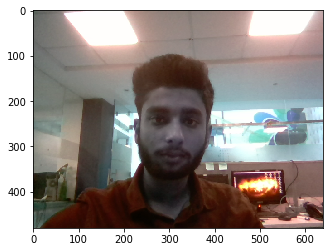

In [43]:
plt.imshow(frame)

In [58]:
n = prewhiten(aligned[0])


W0520 12:40:40.647694 140634822248256 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


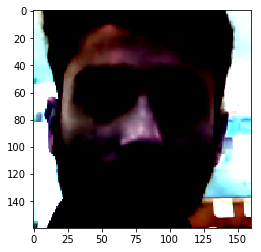

In [59]:
plt.imshow(n)

In [96]:
def align_images(images, margin = 70, image_size = 160):
        try:
            aligned_images = []
            cascade = cv2.CascadeClassifier(cascade_path)
            for img in images:
                #print(filepath)
                if type(img) is list:
                    img = np.array(img)
                img = to_rgb(img)
                try:
                    faces = cascade.detectMultiScale(img,
                                                    scaleFactor=1.1,
                                                    minNeighbors=3)
                    (x, y, w, h) = faces[0]
                    print(faces[0].dtype)
                    cropped = img[y-margin//2:y+h+margin//2,
                                x-margin//2:x+w+margin//2, :]
                    print(cropped.dtype)
                except Exception as e:
                    print("error in face detection")
                    print(e)
                    cropped = img
                img = resize(cropped, (image_size, image_size), mode='reflect')
                #if img.dtype in ('uint8', 'int64'):
                    #img = img.astype('float')/255.
                print(cropped)
                print(img)
                
                #plt.imshow(img)
                #plt.show()
                #img = resize(img, (image_size, image_size), mode='reflect')
                #plt.imshow(img)
                #plt.show()
                aligned_images.append(img)
                return np.array(aligned_images)
        except Exception as e:
            print("Error in Preprocess ")
            print(e)
            return None

In [97]:
aligned = align_images([frame], 50)

int32
uint8
[[[167 150 141]
  [168 151 142]
  [169 152 143]
  ...
  [157 157 157]
  [157 157 157]
  [157 157 157]]

 [[165 149 143]
  [165 149 143]
  [166 150 144]
  ...
  [158 157 160]
  [157 156 159]
  [157 156 159]]

 [[165 149 143]
  [166 150 144]
  [166 150 144]
  ...
  [157 159 161]
  [156 158 160]
  [156 158 160]]

 ...

 [[ 92  60  45]
  [ 90  59  44]
  [ 88  57  42]
  ...
  [ 87  65  48]
  [ 87  69  54]
  [ 88  70  55]]

 [[ 90  57  40]
  [ 90  57  40]
  [ 86  53  35]
  ...
  [ 88  64  47]
  [ 87  67  52]
  [ 90  70  55]]

 [[ 84  50  30]
  [ 84  50  29]
  [ 82  48  26]
  ...
  [ 88  64  47]
  [ 87  67  52]
  [ 89  69  54]]]
[[[0.6507037  0.5850787  0.55474782]
  [0.65364871 0.58802371 0.55769282]
  [0.65386029 0.59017023 0.55824621]
  ...
  [0.61568627 0.61280637 0.61871458]
  [0.61464461 0.61176471 0.61672794]
  [0.61464461 0.61176471 0.61672794]]

 [[0.64393382 0.58118873 0.55686275]
  [0.64705882 0.58431373 0.55998775]
  [0.64785539 0.58613568 0.56207108]
  ...
  [0.615686

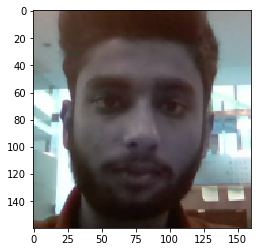

In [89]:
plt.imshow(aligned[0])

In [65]:
del camera